# Compare Rating Curves from the USGS and the NWM

In [1]:
import xarray as xr
import numpy as np
import json
import pandas as pd
import geopandas as gpd
from GageUSGS import GageUSGS

%matplotlib inline

## Functions

In [2]:
def comid_staid_subset_dict(
    state_abrv: str,
    gdf: gpd.GeoDataFrame
) -> dict:
    """
    Subsets the usgs/nhd shapefile and makes a dictionary
    where keys are USGS STAID and values are NHDPlusv2 COMIDs.
    """
    grouped = gdf.groupby('STUSPS')
    st_gdf = grouped.get_group(state_abrv)
    rc_grouped = st_gdf.groupby('HAS_USGS_R')
    st_rc_gdf = rc_grouped.get_group(1)
    return dict(zip(st_rc_gdf.SOURCE_FEA, st_rc_gdf.FLComID))

In [3]:
def get_nwm_rc(comid: int, ds: xr.Dataset) -> pd.DataFrame:
    """Return a specific rating curve for a given comid"""
    subset_ds = ds.Discharge.sel(CatchId=comid)
    nwm_rc = subset_ds.to_dataframe().reset_index().drop(columns=['CatchId']).dropna()
    return nwm_rc

## Parameters

In [4]:
# filepaths 
usgs_nhd_path = r'data/GageLoc/GageLoc_wState.shp'
nwm_rc_path = r'data/hydroprop-fulltable2D.nc'

# open the datasets
ds = xr.open_dataset(nwm_rc_path)
gdf = gpd.read_file(usgs_nhd_path)

## Get dictionary for USGS gages that have rating curves and are in our state of interest

In [5]:
usgs_nhd_nc = comid_staid_subset_dict('NC', gdf)

## Get curves from each source

In [16]:
usgs_rcs = {}
nwm_rcs = {}
for gage, comid in usgs_nhd_nc.items():
    usgs_rc = GageUSGS(gage).rating_curve.dropna()
    usgs_rcs[gage] = usgs_rc
    try:
        nwm_rc = get_nwm_rc(comid, ds)
        nwm_rcs[comid] = nwm_rc
    except KeyError as e:
        print(f'Error on {comid}: {e}')
        nwm_rcs[comid] = None
    
    # Do something with them
    # Statistics 

Error on 1967061: 1967061


In [18]:
for gage, comid in usgs_nhd_nc.items():
    u = usgs_rcs[gage]
    n = nwm_rcs[comid]

# Test Case

In [19]:
gageid = '05418500'
d = dict(zip(gdf.SOURCE_FEA, gdf.FLComID))
d[gageid]

13375649

In [20]:
usgs_rc = GageUSGS(gageid).rating_curve.dropna()
nwm_rc = get_nwm_rc(d[gageid], ds)

In [21]:
from usgs_nwm import new_plot

(0, 12)

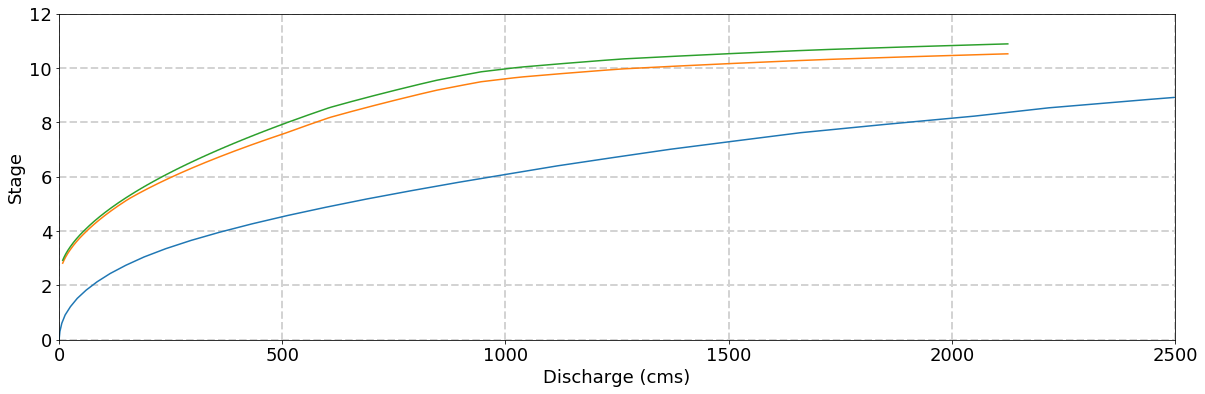

In [22]:
fig, ax = new_plot()
ax.plot(nwm_rc.Discharge, nwm_rc.Stage, label='NWM')
ax.plot(usgs_rc.DEP_cms, usgs_rc.INDEP_m, label='USGS')
ax.plot(usgs_rc.DEP_cms, usgs_rc.INDEP_SHIFT_m, label='USGS Shifted')
ax.set_xlim(0, 2500)
ax.set_ylim(0, 12)